In [1]:
import xarray as xr
import glob
import numpy as np
import cftime
import matplotlib.pyplot as plt

#np.seterr(all='ignore');
import sys
sys.path.append('../src')
import utils as ut

In [2]:
#Get time-independent variables
ds = xr.open_dataset('../data/ecefiles/areas.nc')
area = ds['O1t0.srf'].values;
ds.close()

ds = xr.open_dataset('../data/ecefiles/pi03/pi03_1m_18500101_18501231_grid_T.nc')
lat = ds['nav_lat'].values
lon = ds['nav_lon'].values
time_bnds = ds['time_centered_bounds']
mask = np.where(np.isnan(ds.thetao.isel(olevel=0,time_counter=0)),0,1)
ds.close()
secs = (time_bnds[:,1]-time_bnds[:,0]).values / np.timedelta64(1, 's')

In [23]:
def get_sst(run):
    if run in ['piControl','historical']:
        fnames = sorted(glob.glob(f'../data/ecefiles/cmip6/thetao_Omon_EC-Earth3_{run}*.nc'))
        nyears = len(fnames)
    else:
        fnames = sorted(glob.glob(f'../data/ecefiles/{run}/{run}*.nc'))
        year0 = np.array([int(fname[-27:-23]) for fname in fnames])
        year1 = np.array([int(fname[-18:-14]) for fname in fnames])
        nyears = sum(year1+1-year0)
    print(run,nyears)
    sst = np.zeros((nyears))
    ttime = np.arange(nyears)
    months = np.arange(0,12)

    c = 0
    for f,fname in enumerate(fnames):
        ds = xr.open_dataset(fname,use_cftime=True)
        if run in ['piControl','historical']:
            ds = ds.isel(lev=0)
            time = ds['time'].values
            year0 = int(fname[-16:-12])
        else:
            ds = ds.isel(olevel=0)
            time = ds['time_centered'].values
            year0 = int(fname[-27:-23])
        temp = ds['thetao'].values
        ds.close()

        year0 = int(fname[-16:-12])
        tb = 0
        ny = int(len(time)/12)
        for y in np.arange(0,ny):
            for m,mm in enumerate(months):
                tbb = np.nansum(temp[m+12*y,:,:]*area*mask)/np.nansum(area*mask)
                tb += tbb*secs[m]
            sst[c] = tb/sum(secs)
            print(year0+y,sst[c])
            tb = 0
            c += 1
    print(f'Got SST {run}')
    return sst,ttime

In [24]:
sst_pi,ttime_pi = get_sst('piControl')
sst_hi,ttime_hi = get_sst('historical')
sst_ct,ttime_ct = get_sst('n011')

piControl 501
2259 18.49773765429645
2260 18.558253251934392
2261 18.544615529256905
2262 18.619889710887445
2263 18.62933655245685
2264 18.675805847118987
2265 18.69894230733606
2266 18.52440970519892
2267 18.57959760144237
2268 18.699807085033882
2269 18.66207595661229
2270 18.569147512404815
2271 18.51842552003997
2272 18.686983637461992
2273 18.701814915390496
2274 18.650317310208912
2275 18.701591633845183
2276 18.8047204767092
2277 18.76550592063589
2278 18.69079048941185
2279 18.790687472808973
2280 18.7827752795104
2281 18.684731368173292
2282 18.760132283009852
2283 18.65339489224515
2284 18.667793943294036
2285 18.797976708278302
2286 18.84247479805998
2287 18.68168308913193
2288 18.616633799804138
2289 18.679652201785014
2290 18.753310721885008
2291 18.821279741065954
2292 18.78622777791843
2293 18.7309197379685
2294 18.738935499117975
2295 18.72451499144963
2296 18.759201134371285
2297 18.767956344641572
2298 18.674169763936767
2299 18.700865453161654
2300 18.70757515013286

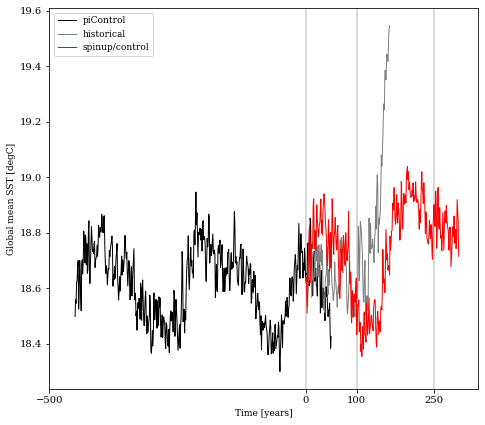

In [44]:
shift = 50
ttime_pi2 = ttime_pi.copy()
sst_pi2 = sst_pi.copy()
#ttime_pi2 = ttime_pi2[:-shift]
#sst_pi2 = sst_pi2[:-shift]
ttime_pi2 += shift-500

fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.plot(ttime_pi2,sst_pi2,c='k',label='piControl')
ax.plot(ttime_hi,sst_hi,c='.5',label='historical')
ax.plot(ttime_ct,sst_ct,c='r',label='spinup/control')
ax.set_xlabel('Time [years]')
ax.set_ylabel('Global mean SST [degC]')
ax.set_xticks([-500,0,100,250])
ax.grid(True,axis='x',linewidth=.3,color='k')
ax.legend()
plt.savefig(f'../draftfigs/global_sst.png',dpi=450)
plt.show()